# Estimate the kappa map for a cluster

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 

import lensit as li
from lensit.clusterlens import lensingmap 
from lensit.misc.misc_utils import gauss_beam
from lensit.ffs_covs import ffs_cov, ell_mat

import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

### 0. We build the simulated maps

In [6]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))
# pars.set_for_lmax(20000)
# pars.set_accuracy(2)
results = camb.get_results(pars)


In [7]:
# We define here the parameters for the profile of the cluster
M200 = 1e15
z = 1
profname = 'nfw'
profparams={'M200c':M200, 'z':z}

# Define here the map square patches
npix = 1024  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 70000 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 3000


# Number of simulated maps 
nsims = 100

# Set CMB experiment for noise level and beam
cmb_exp='S4_opti'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile, profname, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
print(libdir)

/Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_opti/nfw_profile/npix1024_lpix_0.3amin_lmaxsky70000/M200_1.000000E+15_z1/100_sims


In [8]:
camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=ellmaxsky).T
cls_len = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3]}
# cpp_true = results.get_lens_potential_cls(CMB_unit='muK', raw_cl=True, lmax=ellmaxsky).T[0]

In [9]:
# Instantiate the class containing the simulated maps 

clustermaps = lensingmap.cluster_maps(libdir, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, cmb_exp=cmb_exp)


/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:248: RuntimeWarning: invalid value encountered in true_divide
  dx_lm = 2 * rfft_kappa * 1.j * KX / (KX**2+KY**2)
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:249: RuntimeWarning: invalid value encountered in true_divide
  dy_lm = 2 * rfft_kappa * 1.j * KY / (KX**2+KY**2)


In [10]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1) ** 2 * 0.25 

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

### 1. We build the quadratic estimator and initial curvature estimates:

In [11]:
ellmax_sky = clustermaps.ellmax_sky
sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(clustermaps.cmb_exp)

cls_noise = {'t': (sN_uKamin * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'q':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'u':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1)}  # simple flat noise Cls
# cl_transf = gauss_beam(Beam_FWHM_amin / 60. * np.pi / 180., lmax=ellmax_sky)
# lib_alm = ell_mat.ffs_alm_pyFFTW(get_ellmat(LD_res, HD_res=HD_res),
                    # filt_func=lambda ell: (ell >= ellmin) & (ell <= ellmax), num_threads=pyFFTWthreads)
# lib_skyalm = ell_mat.ffs_alm_pyFFTW(clustermaps.ellmat,
                    # filt_func=lambda ell: (ell <= ellmax_sky), num_threads=clustermaps.num_threads)

cl_transf = clustermaps.cl_transf
lib_skyalm = clustermaps.lib_skyalm


typ = 'T'

lib_dir = op.join(clustermaps.dat_libdir, typ)
# isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, cls_len, cl_transf, cls_noise, lib_skyalm=lib_skyalm)
isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, clustermaps.cls_unl, cl_transf, cls_noise, lib_skyalm=lib_skyalm)


In [12]:
ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])

kappa_map = clustermaps.get_kappa_map(clustermaps.M200, clustermaps.z)

ckk_map = lib_skyalm.map2cl(kappa_map)
cpp_map_interp = 10**spline(ell, np.log10(ckk_map[ell]))(np.arange(ellmaxsky+1)) * kk_to_pp(np.arange(ellmaxsky+1))


kappa_ell = clustermaps.haloprofile.analitic_kappa_ft(clustermaps.M200, clustermaps.z, np.arange(ellmax_sky+1))
ckk_fid = kappa_ell **2 
cpp_fid = kk_to_pp(np.arange(ellmax_sky+1))*ckk_fid


cpp_prior = np.copy(cpp_map_interp)
cpp_prior = cpp_prior[:isocov.lib_skyalm.ellmax +1]


ckk_alm = lib_skyalm.map2alm(kappa_map)

ckk_bin = lib_skyalm.bin_realpart_inell(ckk_alm)
# To bin in disk 

ell, = np.where(clustermaps.lib_datalm.get_Nell()[:ellmaxsky+1])
# cpp_prior = cpp_prior * kk_to_pp(np.arange(isocov.lib_skyalm.ellmax +1))

/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:151: RuntimeWarning: invalid value encountered in subtract
  Cidiff = Cixpc - Cix
/Users/louis/Code/LensIt/lensit/clusterlens/profile.py:152: RuntimeWarning: invalid value encountered in true_divide
  u0 = np.sin(x) * Sidiff + np.cos(x) * Cidiff - np.sin(x * c) / (x * (1. + c))


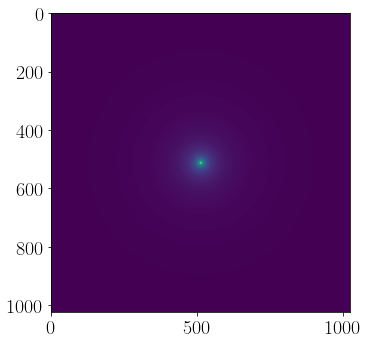

In [13]:
plt.imshow(clustermaps.get_kappa_map(M200*1000, z))

In [14]:
ckk_map

array([5.61355505e-10, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 1.56321917e-34])

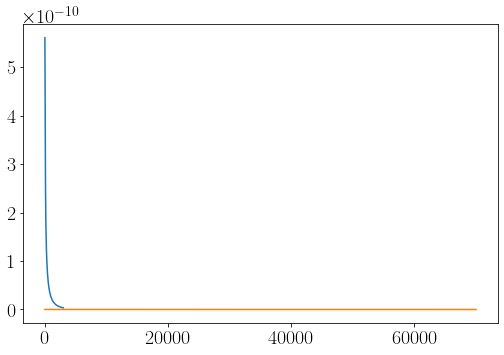

In [15]:
# plt.plot(cpp_prior*pp_to_kk(np.arange(isocov.lib_skyalm.ellmax +1)))


plt.plot(ell, ckk_map[ell])
plt.plot(ckk_fid, label='Th. Cl kappa')

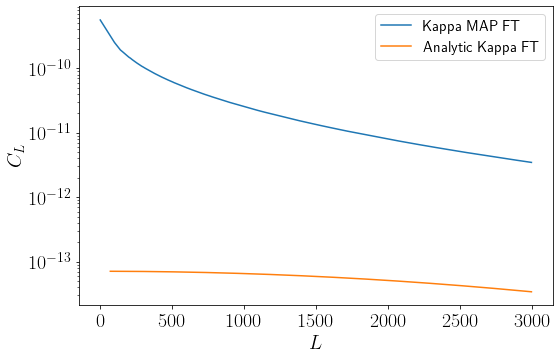

In [16]:

ell, = np.where(lib_skyalm.get_Nell()[:ellmaxdat+1])


plt.plot(ell, ckk_map[ell], label='Kappa MAP FT')
plt.plot(ell, ckk_fid[ell], label='Analytic Kappa FT')

plt.semilogy()

plt.xlabel(r'$L$')
plt.ylabel(r'$C_L$')

plt.legend()

In [17]:
def get_starting_point(idx, typ, clustermaps): 
    """
    This returns initial data for simulation index 'idx' from a CMB-S4 simulation library.
    On first call the simulation library will generate all simulations phases, hence might take a little while.
    """ 

    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
    # isocov.lib_datalm defines the mode-filtering applied on the data, 
    # and isocov.lib_skyalm the band-limits of the unlensed sky.
    lib_qlm = isocov.lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.
    # lib_qlm = isocov.lib_datalm #: This means we will reconstruct the lensing potential for data modes.

    # We now build the Wiener-filtered quadratic estimator. We use lensed CMB spectra in the weights.
    if typ=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in clustermaps.maps_lib.get_sim_qumap(idx)]) 
    elif typ =='T':
        datalms = np.array([isocov.lib_datalm.map2alm(clustermaps.maps_lib.get_sim_tmap(idx))]) 
    
    use_cls_len = False
    
    H0len =  cli(isocov.get_N0cls(typ, lib_qlm, use_cls_len=use_cls_len)[0])
    plm = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len)[0]
    
    # Normalization and Wiener-filtering:
    # cpp_prior = li.get_fidcls()[0]['pp'][:lib_qlm.ellmax+1]

    plmqe  = lib_qlm.almxfl(plm, cli(H0len), inplace=False)
    plm0  = lib_qlm.almxfl(plm, cli(H0len + cli(cpp_prior[:lib_qlm.ellmax+1])), inplace=False)
    wf_qe = np.zeros(lib_qlm.ellmax+1)
    ell, = np.where(lib_qlm.get_Nell()[:isocov.lib_datalm.ellmax])
    
    wf_qe[ell] = cpp_prior[ell] * cli(cpp_prior[ell] + cli(H0len[ell]))
    # wf_qe = cpp_prior[:lib_qlm.ellmax+1] * cli(cpp_prior[:lib_qlm.ellmax+1] + cli(H0len[:lib_qlm.ellmax+1]))
    # wf_qe = spline(ell, wf_qe_0[ell])(np.arange(lib_qlm.ellmax+1))


    # Initial likelihood curvature guess. We use here N0 as calculated with unlensed CMB spectra:
    H0unl =  cli(isocov.get_N0cls(typ, lib_qlm, use_cls_len=False)[0])
    return plm0, plmqe, lib_qlm, datalms, isocov.lib_datalm, H0unl, H0len, wf_qe


idx = 0
plm0, plmqe, lib_qlm, datalms, lib_datalm, H0, H0len, wf_qe = get_starting_point(idx, typ, clustermaps)

 I will be using data from ell=0 to ell=2997 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


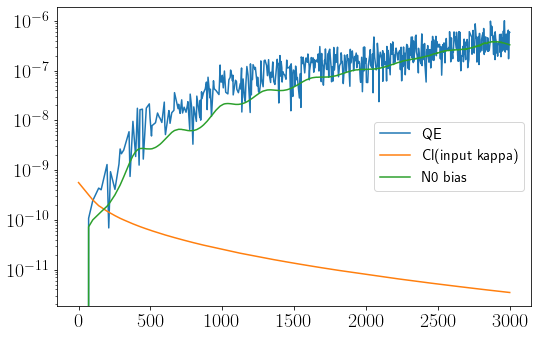

In [18]:
ell, = np.where(lib_qlm.get_Nell()[:ellmaxdat])

kappa_map =clustermaps.get_kappa_map(clustermaps.M200, clustermaps.z)

plt.semilogy(ell, lib_qlm.alm2cl(plmqe)[ell]  * pp_to_kk(ell), label='QE')
plt.plot(ell, lib_qlm.map2cl(kappa_map)[ell], label='Cl(input kappa)')

plt.plot(ell, cli(H0)[ell]*pp_to_kk(ell), label='N0 bias')

plt.legend()


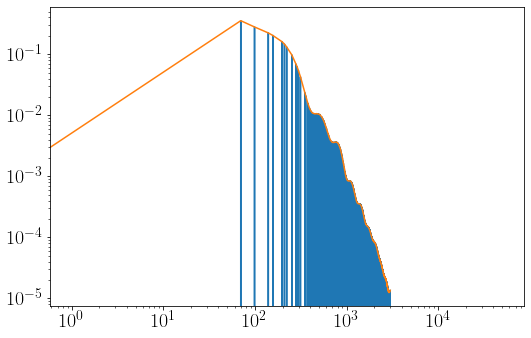

In [19]:
# plt.semilogx(ell, wf_qe[ell])
plt.plot(wf_qe)
plt.loglog(ell, cpp_prior[ell] * cli(cpp_prior[ell] + cli(H0len[ell])))


In [45]:


kappa_input = clustermaps.len_cmbs.kappa_map
phi_input = clustermaps.len_cmbs._get_f().get_phi()


klm_input = lib_qlm.map2alm(kappa_input)
plm_input = lib_qlm.map2alm(phi_input)


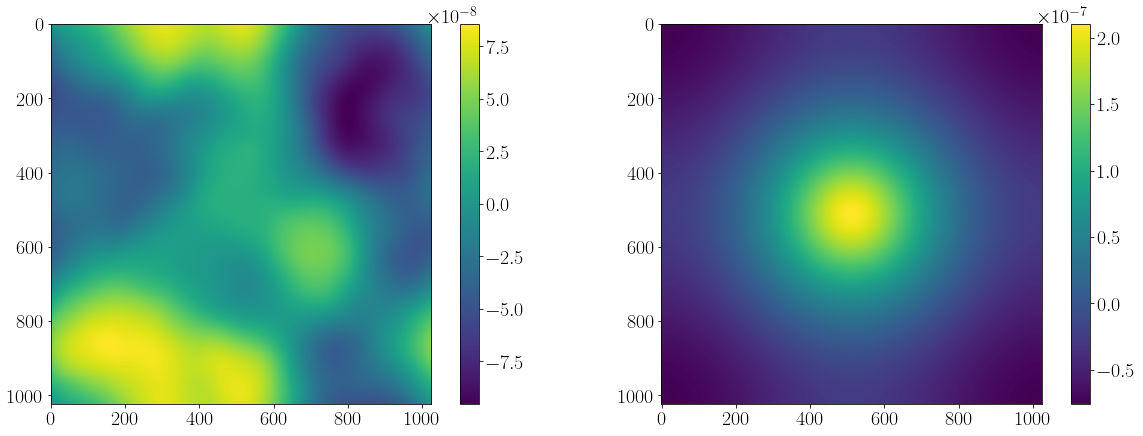

In [52]:
phi_input_wf = lib_qlm.alm2map(lib_qlm.almxfl(plm_input,  wf_qe , inplace=False))

fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1.4, top=0.94, wspace=0.05)
# for ax, dat in zip(axs, [lib_qlm.alm2map(plm2klm(plm0)), clustermaps.len_cmbs.kappa_map]):
for ax, dat in zip(axs, [lib_qlm.alm2map(plm0), phi_input_wf]):
    im = ax.imshow(dat)
    fig.colorbar(im, ax=ax)

# Plotting with the true alpha input or with the WF alpha input gives very difernet visual compairson, 
# But in the end it doesnt matter much as the signal is still there in the reconstructed QE




### 1.2 Make QE on several sims 

In [49]:
nmaps = 10
plm0s = [None]*nmaps
plmqes = [None]*nmaps
pmaps0 = [None]*nmaps
pmapsqe = [None]*nmaps
kmaps = [None]*nmaps
datalms = [None]*nmaps

if nsims >1:
    for idx in range(nmaps):
        print(idx)
        plm0s[idx], plmqes[idx], lib_qlm, datalms[idx], lib_datalm, H0, H0len, wf_qe = get_starting_point(idx, typ, clustermaps)
        # pmaps0[idx] = lib_qlm.alm2map(plm2alphalm(plm0s[idx]))
        # pmapsqe[idx] = lib_qlm.alm2map(plm2alphalm(plmqes[idx]))
        # kmaps[idx] = lib_qlm.alm2map(plm2klm(plm0s[idx]))

        pmaps0[idx] = lib_qlm.alm2map(plm0s[idx])
        pmapsqe[idx] = lib_qlm.alm2map(plmqes[idx])
        # kmaps[idx] = lib_qlm.alm2map(plm2klm(plm0s[idx]))

0
 I will be using data from ell=0 to ell=2997 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
1
 I will be using data from ell=0 to ell=2997 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
2
 I will be using data from ell=0 to ell=2997 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
3
 I will be using data from ell=0 to ell=2997 only
 The sky band-limit is ell=50911
     [00:00:00]  (total [00

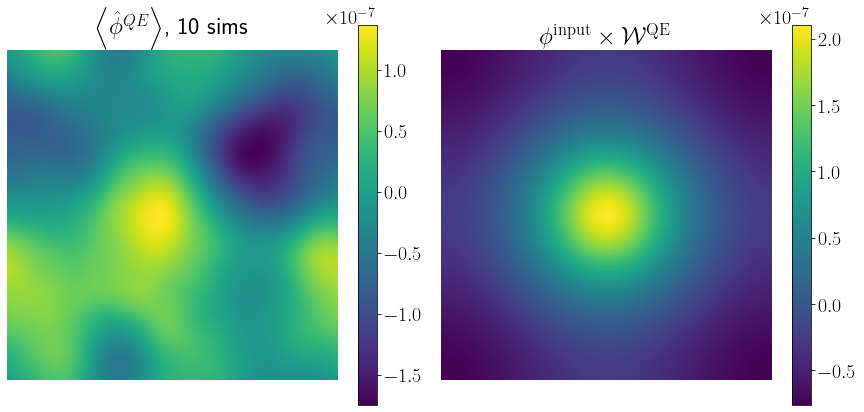

In [51]:
# plt.imshow(np.mean(np.array(pmaps), axis=0))
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1, top=0.94, wspace=0.05)

vmax = np.max(np.abs(phi_input_wf))
titles = [r'$\left< \hat \phi^{QE} \right>$' + f', {nmaps} sims', r'$\phi^{\mathrm{input}} \times \mathcal{W}^{\mathrm{QE}} $']
for ax, dat, title in zip(axs, [np.mean(np.array(pmaps0), axis=0), phi_input_wf], titles):
# for ax, dat, title in zip(axs, [np.mean(np.array(kmaps), axis=0), clustermaps.len_cmbs.kappa_map], titles):
    # im = ax.imshow(dat, vmax = vmax, vmin = -vmax, cmap = 'viridis')
    im = ax.imshow(dat)
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.axis('off')

### 2. We setup the iterator instance:

In [54]:
from lensit.ffs_iterators.ffs_iterator import ffs_iterator_pertMF
from lensit.misc.misc_utils import gauss_beam
from lensit.qcinv import ffs_ninv_filt_ideal, chain_samples
from lensit.ffs_covs import ell_mat

def get_itlib(lib_dir, plm0, lib_qlm,  datalms, lib_datalm, H0, typ, beam_fwhmamin, NlevT_filt, NlevP_filt, verbose=True):
    """
    This returns an iterator instance from the input data maps, lensing map starting point,
    likelihood curvature guess and choice of filtering parameters (ideally close to those of the data).
    """

    if not os.path.exists(lib_dir): 
        os.makedirs(lib_dir)
    # Prior on lensing power spectrum, and CMB spectra for the filtering at each iteration step.
    cls_unl = clustermaps.cls_unl
    # cpp_prior = np.copy(cpp_true)
    
    
    # lib_skyalm = ell_mat.ffs_alm_pyFFTW(lib_datalm.ell_mat, filt_func=lambda ell:ell<=ellmaxsky)
                            #: This means we perform here the lensing of CMB skies at the same resolution 
                            #  than the data with the band-limit of 6000.
    lib_skyalm = clustermaps.lib_skyalm
    # transf = gauss_beam(beam_fwhmamin / 180. / 60. * np.pi, lmax=ellmaxsky) #: fiducial beam
    
    # Anisotropic filtering instance, with unlensed CMB spectra as inputs. Delfections will be added by the iterator.
    cl_transf = gauss_beam(Beam_FWHM_amin / 60. * np.pi / 180., lmax=lib_skyalm.ellmax)
    filt = ffs_ninv_filt_ideal.ffs_ninv_filt(lib_datalm, lib_skyalm, cls_unl, cl_transf, NlevT_filt, NlevP_filt)
    
    # Description of the multi-grid chain to use: (here the simplest, diagonal pre-conditioner) 
    chain_descr = chain_samples.get_isomgchain(filt.lib_skyalm.ellmax, filt.lib_datalm.shape,
                                                        tol=1e-6,iter_max=200)
    
    # We assume no primordial B-modes, the E-B filtering will assume all B-modes are either noise or lensing:
    opfilt =  li.qcinv.opfilt_cinv_noBB
    opfilt._type = typ 
    
    # With all this now in place, we can build the iterator instance:
    iterator = ffs_iterator_pertMF(lib_dir, typ, filt, datalms, lib_qlm, 
              plm0, H0, cpp_prior, chain_descr=chain_descr, opfilt=opfilt, verbose=verbose)
               # We use here an iterator instance that uses an analytical approximation 
               # for the mean-field term at each step.
    return iterator

# lib_dir = os.path.join(os.environ['LENSIT'], 'temp', 'iterator_S4_sim%03d'%0)

itlibdir = lambda idx: op.join(lib_dir, f'iterator_S4_sim{idx:04d}')

itlib = get_itlib(itlibdir(0), plm0, lib_qlm, datalms[0], lib_datalm, H0, typ, beam_fwhmamin=Beam_FWHM_amin, NlevT_filt=sN_uKamin, NlevP_filt=sN_uKaminP)

 I see t 1.0
 I see q 1.4142135623730951
 I see u 1.4142135623730951
ffs iterator : This is 0 trying to setup /Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_opti/nfw_profile/npix1024_lpix_0.3amin_lmaxsky70000/M200_1.000000E+15_z1/100_sims/lmaxdat3000/T/iterator_S4_sim0000
++ ffs_<class 'type'> masked iterator : setup OK


### 3. We perform the iterations:
This should take about ~ 1 min. to finish. A lot of print-out in verbose mode.

In [55]:
itlib.soltn_cond = True
for i in range(10):
    itlib.iterate(i, 'p')

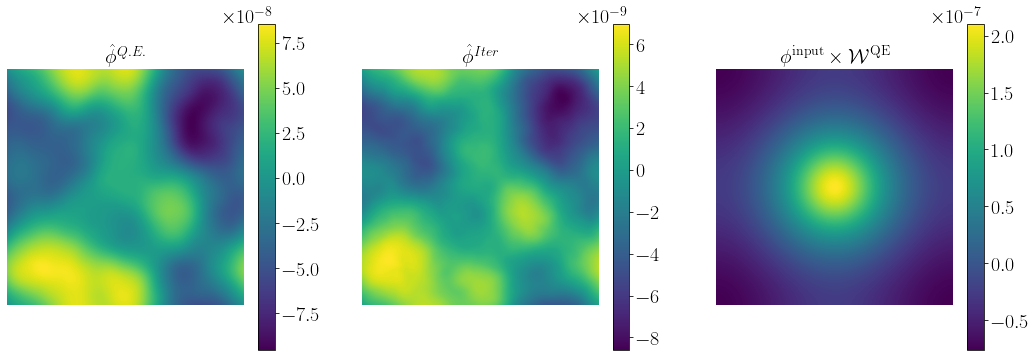

In [57]:
# plm2alphalm = lambda plm : lib_qlm.almxfl(plm, np.arange(lib_qlm.ellmax + 1))


fig, axs = plt.subplots(1, 3, figsize=(18, 6),)


vmax = np.max(np.abs(phi_input_wf))
datas = [lib_qlm.alm2map(itlib.get_Plm(0, 'p')), lib_qlm.alm2map(itlib.get_Plm(9, 'p')), phi_input_wf]
titles = [r'$\hat \phi^{Q.E.}$', r'$\hat \phi^{Iter}$', r'$\phi^{\rm input} \times \mathcal{W}^{\mathrm{QE}}$']

for ax, dat, title in zip(axs, datas, titles):
    im = ax.imshow(dat) #,  vmax = vmax, vmin= -vmax)
    ax.set_title(title, fontsize=20)
    ax.axis('off')  
    fig.colorbar(im, ax=ax)



In [58]:
plmits = [None]*nmaps
itlibs = [None]*nmaps

if nsims >1:
    for idx in range(nmaps):
        print(idx)
        itlibs[idx] = get_itlib(itlibdir(idx), plm0s[idx], lib_qlm, datalms[idx], lib_datalm, H0, typ, beam_fwhmamin=Beam_FWHM_amin, NlevT_filt=sN_uKamin, NlevP_filt=sN_uKaminP, verbose=False)
        itlibs[idx].soltn_cond = True
        for i in range(10):
            itlibs[idx].iterate(i, 'p')
        plmits[idx]= itlibs[idx].get_Plm(9, 'p')

0
ffs iterator : This is 0 trying to setup /Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_opti/nfw_profile/npix1024_lpix_0.3amin_lmaxsky70000/M200_1.000000E+15_z1/100_sims/lmaxdat3000/T/iterator_S4_sim0000
++ ffs_<class 'type'> masked iterator : setup OK
1
ffs iterator : This is 0 trying to setup /Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_opti/nfw_profile/npix1024_lpix_0.3amin_lmaxsky70000/M200_1.000000E+15_z1/100_sims/lmaxdat3000/T/iterator_S4_sim0001
++ ffs_<class 'type'> masked iterator : setup OK
2
ffs iterator : This is 0 trying to setup /Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_opti/nfw_profile/npix1024_lpix_0.3amin_lmaxsky70000/M200_1.000000E+15_z1/100_sims/lmaxdat3000/T/iterator_S4_sim0002
++ ffs_<class 'type'> masked iterator : setup OK
3
ffs iterator : This is 0 trying to setup /Users/louis/Code/LensIt/lensit_write/temp/clustermaps/camb_planck_2018_acc

In [59]:
qe_maps = np.array([lib_qlm.alm2map(itlibs[idx].get_Plm(0, 'p')) for idx in range(nmaps)])
it_maps = np.array([lib_qlm.alm2map(plmits[idx]) for idx in range(nmaps)])

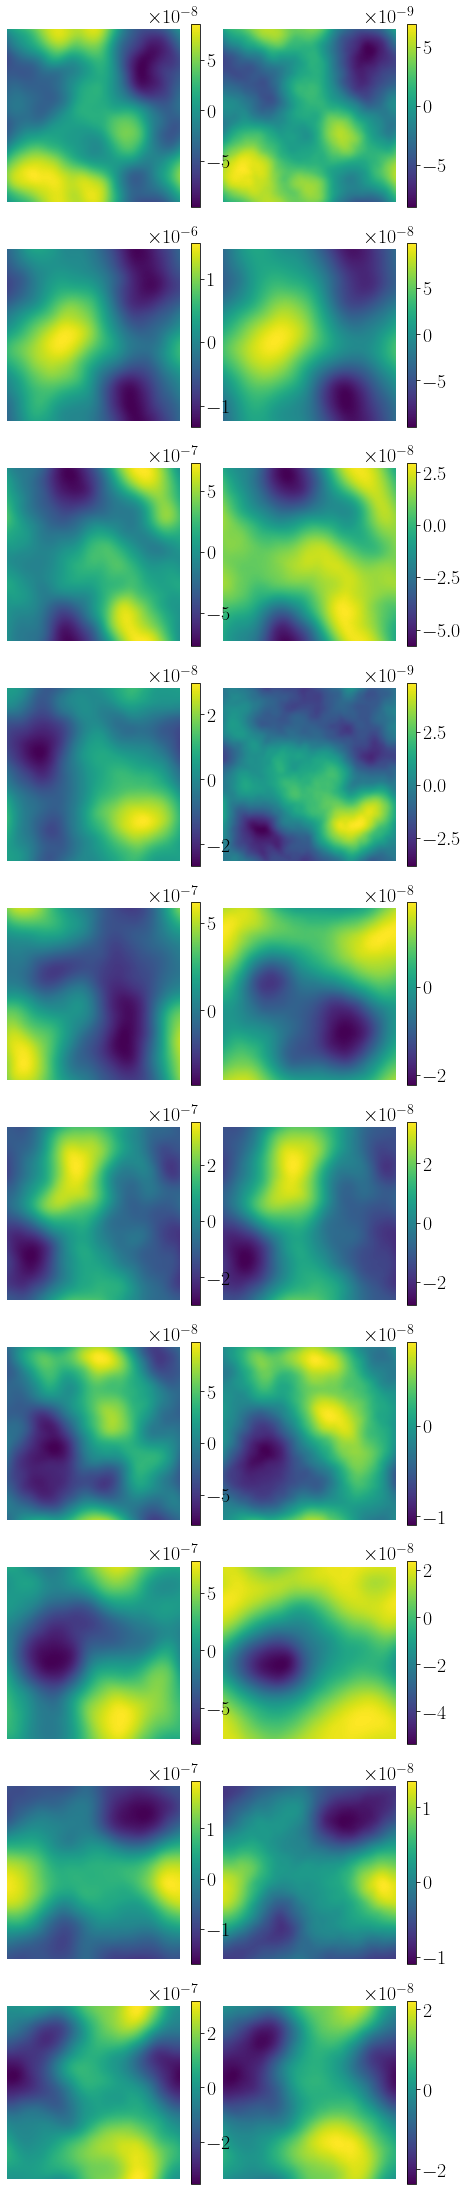

In [60]:
fig, axs = plt.subplots(10, 2, figsize=(6, 30),)
fig.subplots_adjust(left=0., bottom=0., right=1, top=1, wspace=0.0)

#     plt.figure()
#     plt.imshow(it_maps[idx])


# for ax, dat, title in zip(axs, datas, titles):

vmax = np.max(np.abs(it_maps))
for idx in range(10):
    imqe = axs[idx, 0].imshow(qe_maps[idx])
    imit = axs[idx, 1].imshow(it_maps[idx])
    # ax.set_title(title, fontsize=20)
    axs[idx, 0].axis('off')  
    axs[idx, 1].axis('off')  
    fig.colorbar(imqe, ax=axs[idx, 0])
    fig.colorbar(imit, ax=axs[idx, 1])
    # fig.colorbar(im, ax=ax)

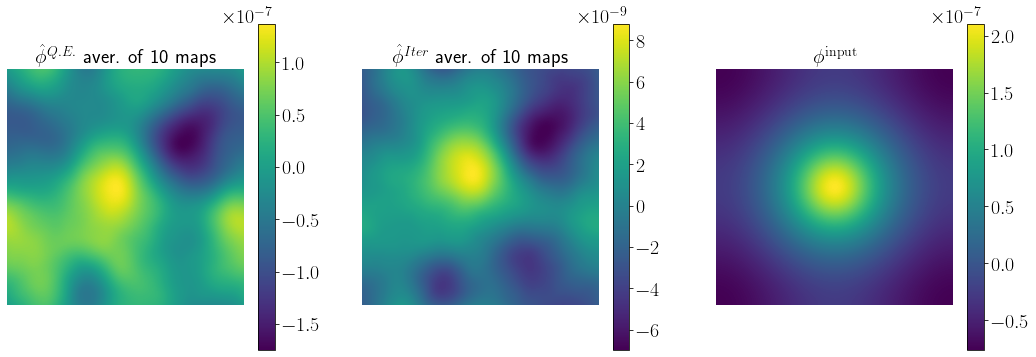

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6),)

vmax = np.max(np.abs(phi_input_wf))
datas = [np.mean(qe_maps, axis=0), np.mean(it_maps, axis=0), phi_input_wf]
titles = [r'$\hat \phi^{Q.E.}$' + f" aver. of {qe_maps.shape[0]} maps", r'$\hat \phi^{Iter}$' + f" aver. of {it_maps.shape[0]} maps", r'$\phi^{\rm input}$']

for ax, dat, title in zip(axs, datas, titles):
    # im = ax.imshow(dat, vmax = vmax, vmin= -1e-6)
    im = ax.imshow(dat)
    ax.set_title(title, fontsize=20)
    ax.axis('off')
    fig.colorbar(im, ax=ax)
